# Global Landslide Analysis

Through this analysis I aim to answer the following questions:
- What causes Landslides?
- Where do Most Landslides happen?
- How often do Landslides happen?
- How dangerous are Landslides?

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing data

df = pd.read_csv('Global_Landslide_Catalog_Export_20240609.csv')

# Cleaning up the data

In [3]:
# Removing Information that will not be used from our data
landslide_data = df.drop(['source_link','photo_link','event_time','event_title','event_description','location_description','location_accuracy','gazeteer_closest_point','gazeteer_distance','submitted_date','created_date','last_edited_date','event_import_id','event_id','notes','event_import_source'],axis=1)

# removing events with unknown trigger
landslide_data = landslide_data[landslide_data['landslide_trigger'] != 'unknown']

# setting the numerical type data null values to the mean value of their categories
landslide_data[['fatality_count','injury_count','admin_division_population']] = landslide_data[['fatality_count','injury_count','admin_division_population']].fillna(landslide_data[['fatality_count','injury_count','admin_division_population']].mean())



# What Causes Landslides?

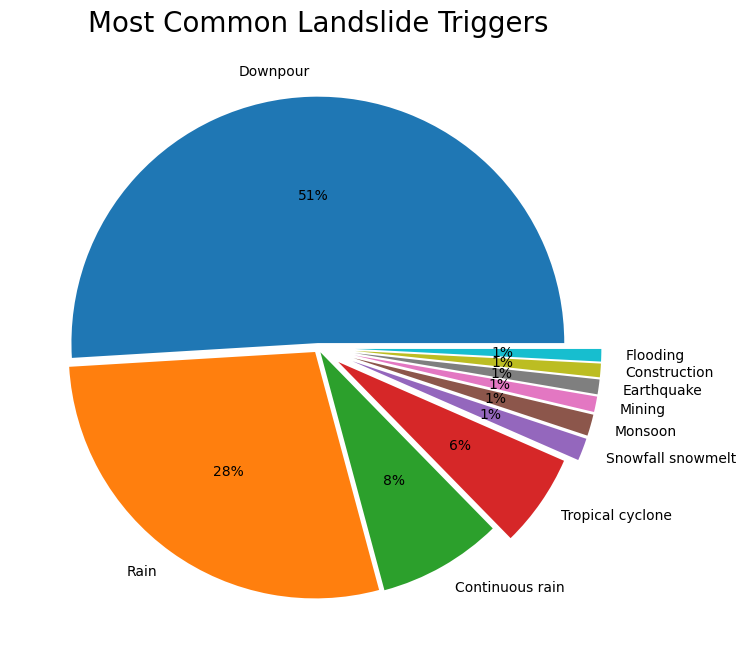

In [4]:
# Find out the most common types of Landslide triggers
top_trigger_counts = landslide_data['landslide_trigger'].value_counts().reset_index().head(10)

# format labels properly
my_labels = []

for i in top_trigger_counts['landslide_trigger']:
  my_labels.append(i.replace('_',' ').capitalize())

# plot data and format plot
fig, ax = plt.subplots(figsize=(8,8))
explode = [0.02,0.02,0.02,0.1,0.15,0.15,0.15,0.15,0.15,0.15]

plt.pie(top_trigger_counts['count'], labels=my_labels, autopct='%.0f%%', explode=explode)

plt.title('Most Common Landslide Triggers', fontsize=20)
plt.show()

# Where do most Landslides happen?

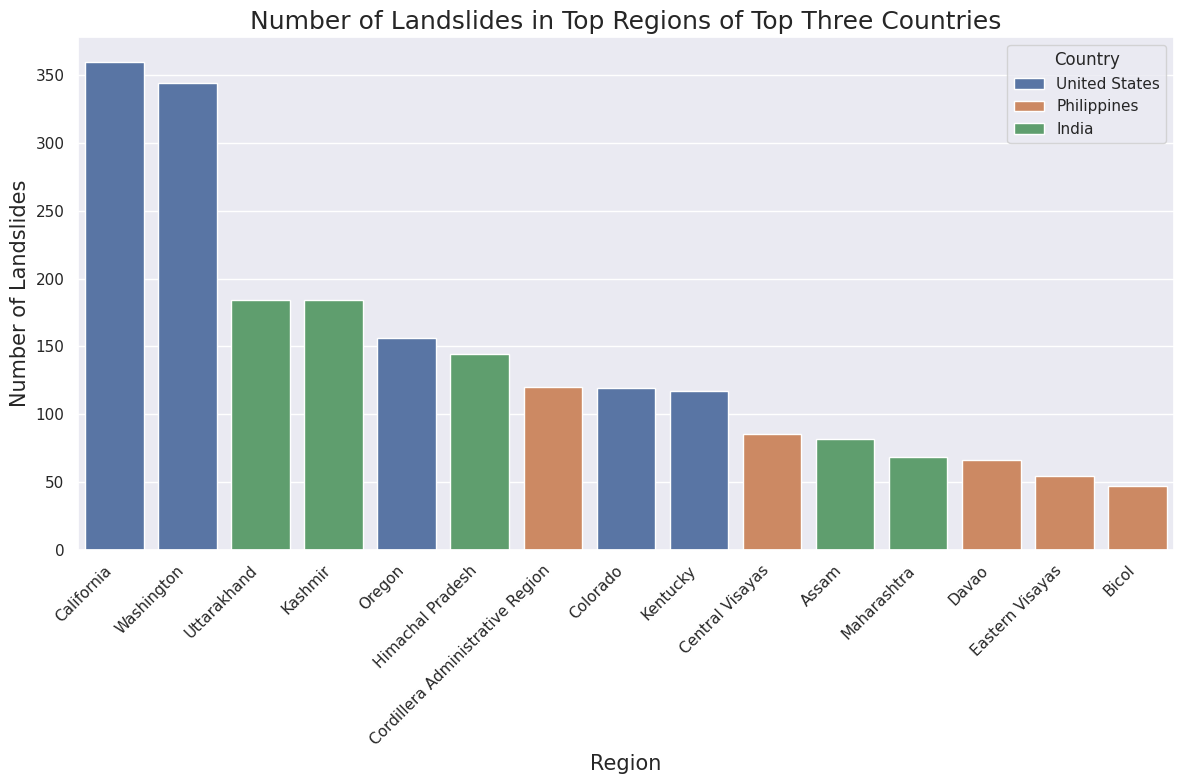

In [10]:
# Finding most common Countries, region and settings where landslides happen
top_countries = landslide_data['country_name'].value_counts().head(3).index

# Filter the dataset to include top 3 countries and top 5 regions per country
top_countries_data = landslide_data[landslide_data['country_name'].isin(top_countries)]
top_regions_data = top_countries_data.groupby(['country_name', 'admin_division_name']).size().reset_index(name='count')
top_regions_data = top_regions_data.sort_values(by=['country_name', 'count'], ascending=[True, False])
top_5_regions_per_country = top_regions_data.groupby('country_name').head(5)

final_data = landslide_data[(landslide_data['country_name'].isin(top_5_regions_per_country['country_name'])) &
                            (landslide_data['admin_division_name'].isin(top_5_regions_per_country['admin_division_name']))]

# Calculate the count of landslides for each region
region_counts = final_data['admin_division_name'].value_counts()
region_order = region_counts.index

# Plot and formatting
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.countplot(data=final_data, x='admin_division_name', hue='country_name', order=region_order)
plt.title('Number of Landslides in Top Regions of Top Three Countries',fontsize=18)
plt.xlabel('Region', fontsize=15)
plt.ylabel('Number of Landslides', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country', loc='upper right')
plt.tight_layout()
plt.show()

# How often do Landslides happen?

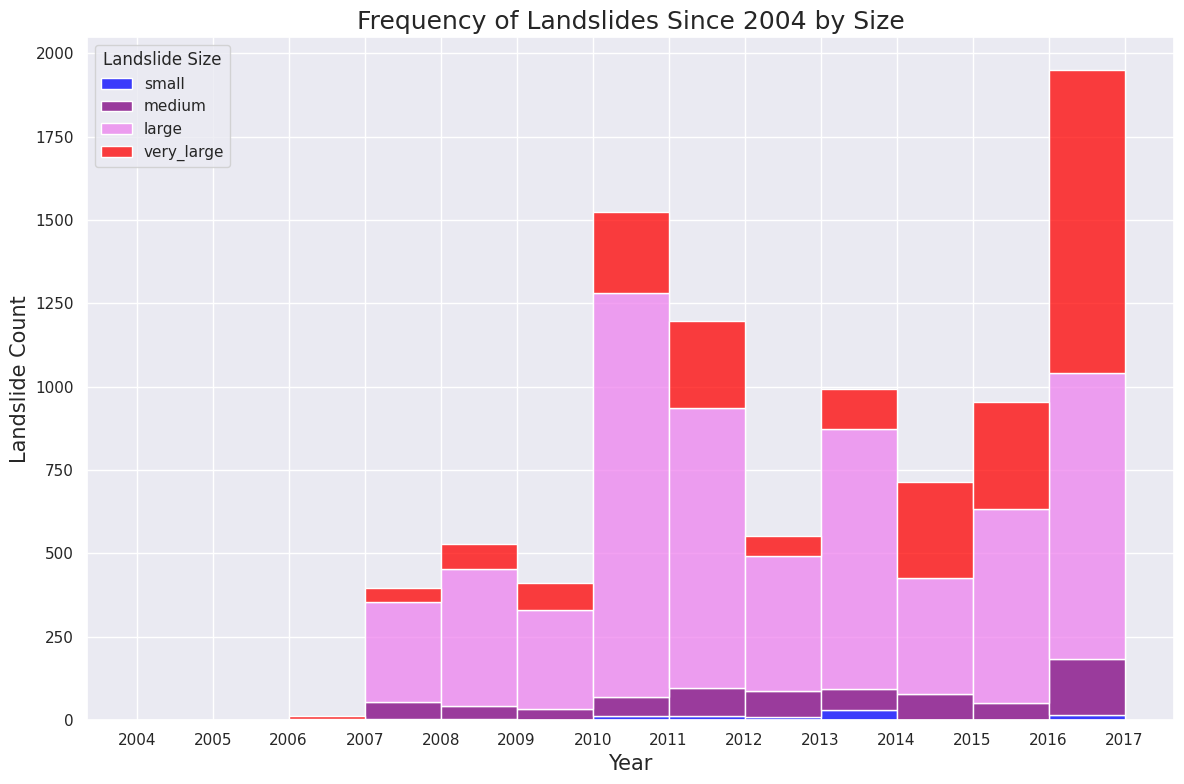

In [115]:
# custom color
custom_palette = ['red','violet','purple','blue']

# Filter data
landslide_data_since_2004 = landslide_data[
    (pd.to_datetime(landslide_data['event_date'], format='%m/%d/%Y %I:%M:%S %p').dt.year >= 2004) &
    (landslide_data['landslide_size'].notna()) &
    (landslide_data['landslide_size'] != 'unknown') &
    (landslide_data['landslide_size'] != 'catastrophic')
].copy()

# Extract year
landslide_data_since_2004['year'] = pd.to_datetime(landslide_data_since_2004['event_date'], format='%m/%d/%Y %I:%M:%S %p').dt.year

# Plot
plt.figure(figsize=(12,8))
sns.histplot(data=landslide_data_since_2004, x='year', hue='landslide_size', hue_order=['small', 'medium', 'large', 'very_large'], bins=range(2004, landslide_data_since_2004['year'].max()+1), multiple='stack', palette=custom_palette)

# order legend labels
legend_order = ['small', 'medium', 'large', 'very_large']
ordered_sizes = [size for size in legend_order]

plt.legend(title='Landslide Size', labels=ordered_sizes, loc='upper left')

# formatting
plt.title('Frequency of Landslides Since 2004 by Size', fontsize=18)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Landslide Count', fontsize=15)
plt.xticks(range(2004, landslide_data_since_2004['year'].max()+1))
plt.tight_layout()
plt.show()

# How Dangerous are Landslides by Size?

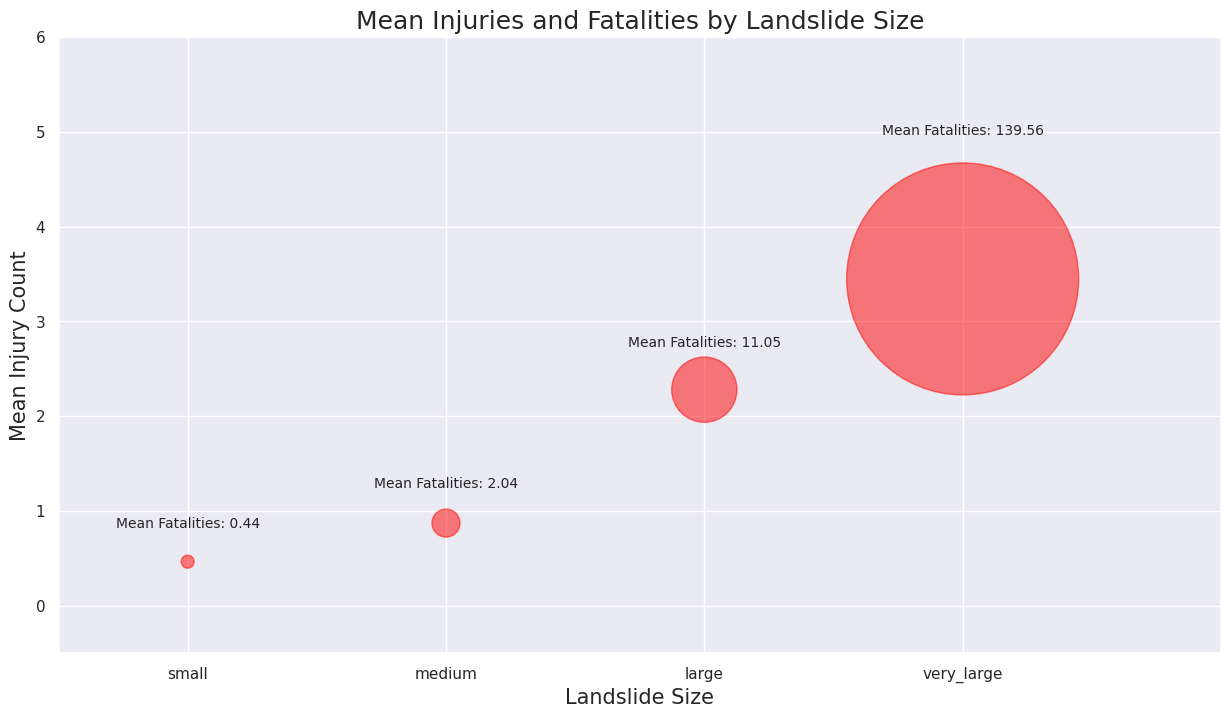

In [131]:
# Filter data
landslide_data_filtered = landslide_data[(landslide_data['landslide_size'].notna()) &
                                         (landslide_data['landslide_size'] != 'unknown') &
                                         (landslide_data['landslide_size'] != 'catastrophic')].copy()

# Group the data by size and calculate mean fatalities and injuries
grouped_data = landslide_data_filtered.groupby('landslide_size').agg({'fatality_count': 'mean', 'injury_count': 'mean'})

# Order data
category_order = ['small', 'medium', 'large', 'very_large']
grouped_data = grouped_data.reindex(category_order)

# Plot
plt.figure(figsize=(15, 8))

scatter = plt.scatter(range(len(grouped_data)),
                      grouped_data['injury_count'],
                      s=grouped_data['fatality_count']*200,  # Adjust the scaling factor as needed
                      alpha=0.5,
                      c='red')

# Adding labels
for i, txt in enumerate(grouped_data['fatality_count']):
    offset = (grouped_data['fatality_count'][i] / 120) + .4  # Adjust the scaling factor as needed
    plt.text(i, grouped_data['injury_count'][i] + offset, f'Mean Fatalities: {txt:.2f}', ha='center', va='center', fontsize=10)

# Formatting
plt.xlabel('Landslide Size', fontsize=15)
plt.ylabel('Mean Injury Count', fontsize=15)
plt.title('Mean Injuries and Fatalities by Landslide Size', fontsize=18)

# Adjusting x labels
plt.xticks(range(len(grouped_data)), grouped_data.index)
plt.xlim(-0.5, len(grouped_data))
plt.ylim(-0.5, 6)

plt.show()